<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
pip install --upgrade pip -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install -U scikit-learn -q

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install --upgrade catboost -q

Note: you may need to restart the kernel to use updated packages.


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import warnings
import os

from scipy import stats as st
from numpy.random import RandomState

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, ElasticNet
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool, cv
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import (mean_absolute_error, mean_squared_error, make_scorer)
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [5]:
warnings.filterwarnings('ignore')

In [6]:
RANDOM_STATE = 42

## Подготовка

Из описания данных, мы уже знаем, что в них содержится два столбца: дата и количество заказов такси. На этапе считывания спарсим дату и зададим ее в качестве индекс-столбца.

In [7]:
pth_1 = '/datasets/taxi.csv'
pth_2 = 'C:/Users/ASUS/Desktop/PRACTICUM/Мои проекты/Taxi/taxi.csv'

if os.path.exists(pth_1):
    taxi = pd.read_csv(pth_1, index_col=[0], parse_dates=[0])
elif os.path.exists(pth_2):
    taxi = pd.read_csv(pth_2, index_col=[0], parse_dates=[0])
else:
    print('Что-то пошло не так..')


In [8]:
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [9]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [10]:
taxi.index.is_monotonic

True

Данные загружены корректно, даты расположены в хронологическом порядке. В нашем распоряжении информация о поездках в период с марта по август 2018 года.

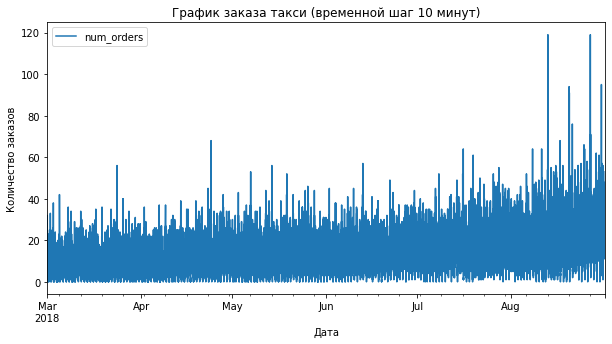

In [11]:
taxi.plot(figsize=(10, 5))
plt.title('График заказа такси (временной шаг 10 минут)')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

Ресеплируем данные по одному часу:

In [12]:
taxi = taxi.resample('1H').sum()

Теперь с помощью функции создадим новые признаки: месяц, день, день недели, отстающие значения и скользящее среднее. Сразу добавим удаление пустых ячеек, возникающих из-за сдвига значений.

In [13]:
def make_features(data):
     new_data = data.copy()
     new_data['hour'] = new_data.index.hour
     new_data['dayofweek'] = new_data.index.dayofweek
     return new_data
data = make_features(taxi)

## Анализ

In [15]:
def first_step(data):
    display(data.head())
    display(data.tail())
    print('Информация о датафрейме:')
    display(data.info())
    print(f'\nКоличество пропущенных значений в каждом столбце:\n{data.isna().sum()} \n')
    print(f'Количество дубликатов в индексах:\n{data.index.duplicated().sum()} \n')
    print(f'Количество уникальных значений в каждом столбце:\n{data.nunique()}')

In [16]:
first_step(data)

,num_orders,hour,dayofweek
datetime,,,
2018-03-01 00:00:00,124,0,3
2018-03-01 01:00:00,85,1,3
2018-03-01 02:00:00,71,2,3
2018-03-01 03:00:00,66,3,3
2018-03-01 04:00:00,43,4,3


,num_orders,hour,dayofweek
datetime,,,
2018-08-31 19:00:00,136,19,4
2018-08-31 20:00:00,154,20,4
2018-08-31 21:00:00,159,21,4
2018-08-31 22:00:00,223,22,4
2018-08-31 23:00:00,205,23,4


Информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
 1   hour        4416 non-null   int64
 2   dayofweek   4416 non-null   int64
dtypes: int64(3)
memory usage: 138.0 KB


None


Количество пропущенных значений в каждом столбце:
num_orders    0
hour          0
dayofweek     0
dtype: int64 

Количество дубликатов в индексах:
0 

Количество уникальных значений в каждом столбце:
num_orders    251
hour           24
dayofweek       7
dtype: int64


Признаки 'dayofweek' и 'hour' можно отнести к дискретным величинам. Пропусков и дубликатов нет.

In [17]:
def orders(data, period):
    
    grouped_data = data.groupby(period)['num_orders'].sum()
    
    ax = grouped_data.plot(kind='bar', figsize=(10, 5))
    plt.title(f'Заказы такси по {period}')
    plt.xlabel(period)
    plt.ylabel('Количество заказов')
    ax.set_ylim(grouped_data.max() * 0.3, grouped_data.max() * 1.01)
    plt.show()

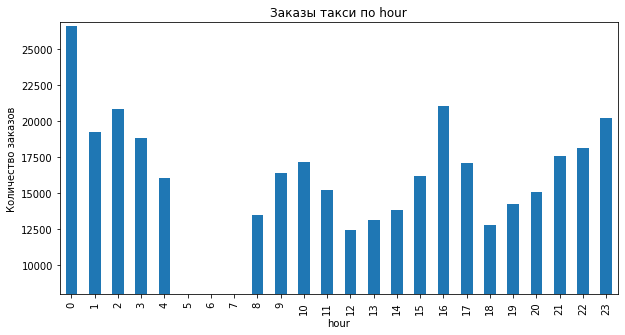

In [18]:
orders(data, 'hour')

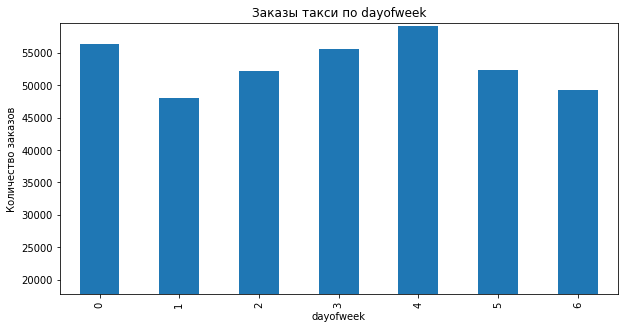

In [20]:
orders(data, 'dayofweek')

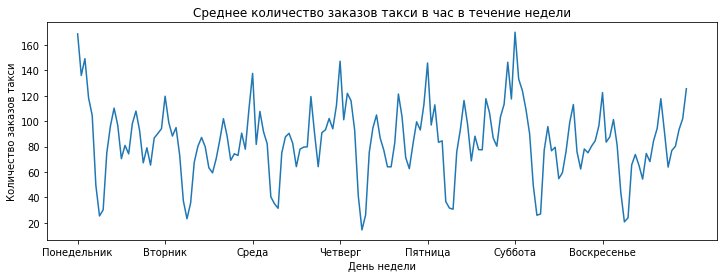

In [21]:
fig, ax = plt.subplots(figsize=(12, 4))
average_week_demand = data.groupby(['dayofweek', 'hour'])['num_orders'].mean()
average_week_demand.plot(ax=ax)
_ = ax.set(
    title='Среднее количество заказов такси в час в течение недели',
    xticks=[i * 24 for i in range(7)],
    xticklabels=['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Cуббота', 'Воскресенье'],
    xlabel='День недели',
    ylabel='Количество заказов такси'
)

Немного чаще прочих дней услугами такси пользуются по понедельникам, четвергам и пятницам. Низким спросом такси пользуется утром с 5 до 8 часов, а высоким - в полночь и в 16 часов. Заметно, что в понедельник большое количество людей прилетает (возможно, после выходных) в короткий период после полуночи, а в пятницу - большое количество прилетающих вечером. 

In [22]:
data['num_orders'].describe()

count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64

В основном, каждый час сумма заказов не превышает 100. В среднем в час такси заказывают около 84 раз. В редких случаях служба получает свыше 200 заказов, в самый нагруженный час было 462 заказа. Посмотрим на распределение доли количества заказов от максимального количества (гистограмму нормализованных данных).


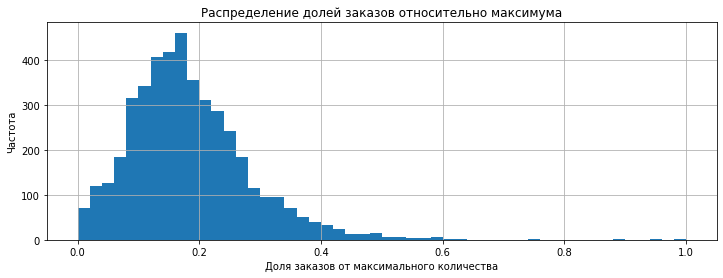

In [23]:
fig, ax = plt.subplots(figsize=(12, 4))
(data['num_orders']/data['num_orders'].max()).hist(bins=50, ax=ax)
_ = ax.set(
    xlabel='Доля заказов от максимального количества',
    ylabel='Частота',
    title='Распределение долей заказов относительно максимума',
)

Большинство заказов сосредоточено около 0,18 доли от максимального количества заказов, это значит, что около 80 заказов в час - это наиболее типичное (или характерное) количество. График распределения скошен влево, это значит, что более 200 заказов случаются крайне редко.

Разложим временной ряд на три составляющие: тренд, сезонность и остаток.

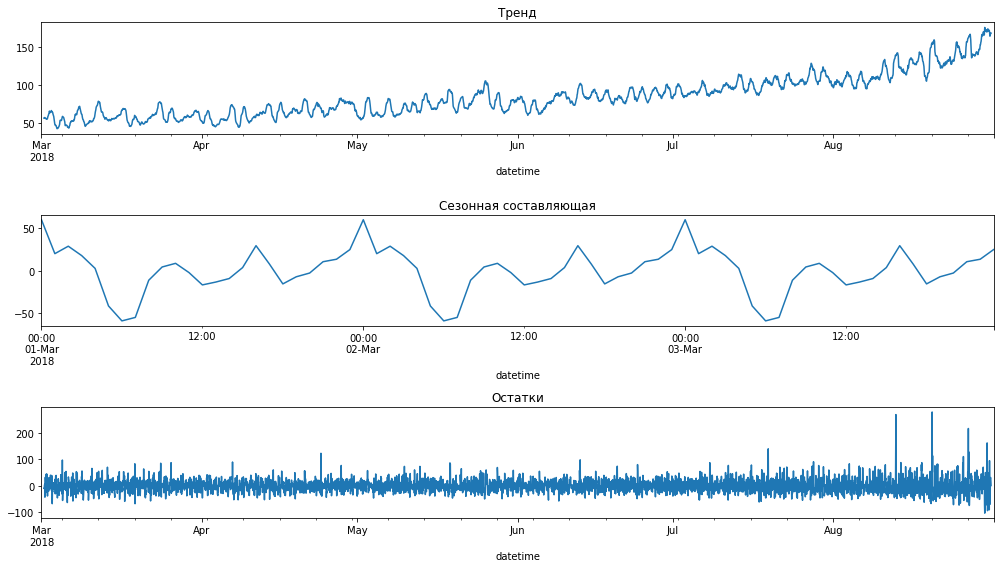

In [24]:
decomposed = seasonal_decompose(data['num_orders'])
plt.figure(figsize=(14, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-03-03'].plot(ax=plt.gca())
plt.title('Сезонная составляющая')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки')
plt.tight_layout()

Тренд представляет собой долгосрочное изменение в данных: мы наблюдаем рост количества заказов такси. Сезонность — это циклические изменения данных, которые повторяются с постоянным интервалом времени: мы наблюдаем одинаковые пиковые спросы на такси в полночь, спад ранним утром и новый пик около 16 часов. Ошибки представляют собой случайные колебания данных, которые не подчиняются определенным закономерностям. Это может быть вызвано различными факторами, такими как случайные события или ошибки измерения.

In [25]:
def make_new_features(data, max_lag, rolling_mean_size):
    new_data = data.copy()
    
    for lag in range(1, max_lag + 1):
        new_data['lag_{}'.format(lag)] = new_data['num_orders'].shift(lag)
    
    new_data['rolling_mean'] = new_data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return new_data.dropna()

Зададим 24 столбца с отстающими значениями и установим размер окна скользящего среднего равным суткам (24 часа).

In [26]:
data = make_new_features(data, 24, 24)

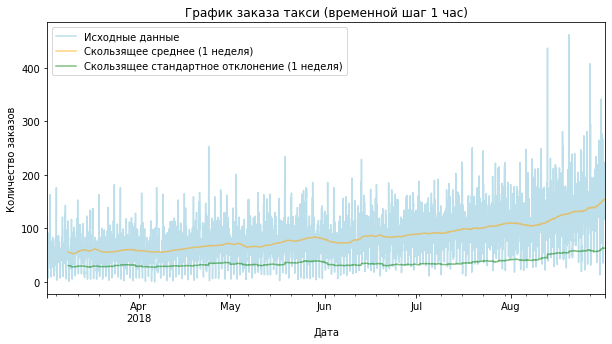

In [27]:
plt.figure(figsize=(10, 5))
plt.title('График заказа такси (временной шаг 1 час)')
data['num_orders'].plot(label='Исходные данные', color='lightblue', alpha=0.8)
data['num_orders'].rolling(168).mean().plot(label='Скользящее среднее (1 неделя)', color='orange', alpha=0.5)
data['num_orders'].rolling(168).std().plot(label='Скользящее стандартное отклонение (1 неделя)', color='green', alpha=0.5)
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.legend()
plt.show()

Скользящее среднее меняется со временем, и есть общий тренд на увеличение количества заказов такси, что может говорить о нестационарности временного ряда, но мы определили повторяющиеся циклы активности в течение каждого дня, что может говорить о том, что статистические свойства остаются постоянными и не изменяются с течением времени.

Рассмотрим графики автокорреляции (ACF) и частичной автокорреляции (PACF)

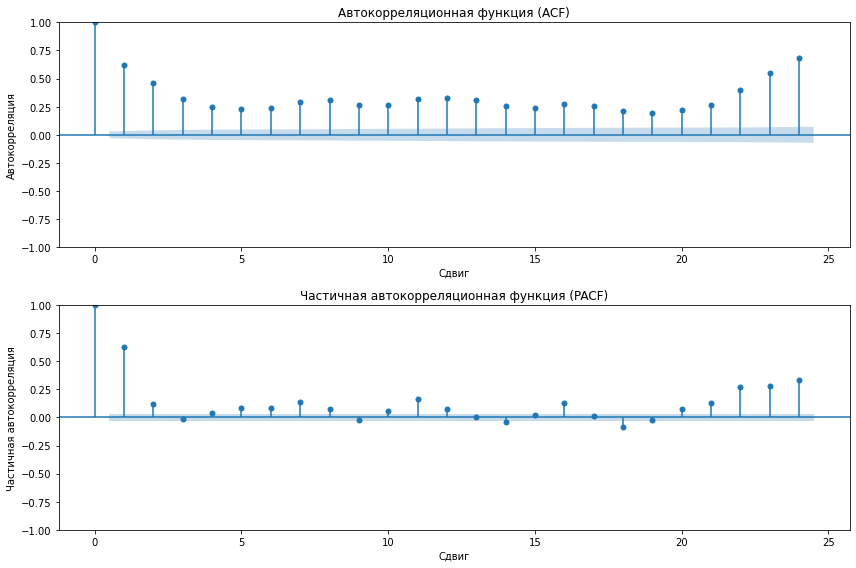

In [28]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(data['num_orders'], ax=ax[0], lags=24)
ax[0].set_title('Автокорреляционная функция (ACF)')
ax[0].set_xlabel('Сдвиг')
ax[0].set_ylabel('Автокорреляция')

plot_pacf(data['num_orders'], ax=ax[1], lags=24)
ax[1].set_title('Частичная автокорреляционная функция (PACF)')
ax[1].set_xlabel('Сдвиг')
ax[1].set_ylabel('Частичная автокорреляция')

plt.tight_layout()
plt.show()

На графике ACF мы видим, что текущее значение временного ряда сильнее всего коррелирует с предыдущим значением ряда, а также со значениями 23 и 24-часовой давности, наименьшая связь со значениями 5 и 19 часов назад. Все значения находятся за пределами доверительных интервалов, что делает корреляцию значимой.

Исключив влияние промежуточных значений (график PACF), мы видим, что значимая частичная автокорреляция имеется со значениями 2 часов, 22, 23, и 24 часов, т.е. они имеют прямое влияние на текущее значение.

Для проверки стационарности ряда проведем тест Дики-Фуллера, который реализован в модуле statsmodels. Основная идея теста заключается в подтверждении или отклонении двух гипотез:

Нулевая гипотеза (H0): Временной ряд имеет единичный корень и нестационарен (такси вызываются в случайном порядке).

Альтернативная гипотеза (H1): предполагает, что временной ряд не имеет единичного корня, то есть он является стационарным. Если эта гипотеза верна, то в заказах такси сохраняется закономерность.

In [29]:
result = adfuller(data['num_orders'])
print('p-value: %f' % result[1])

if result[1] > 0.01:
    print('Временной ряд не стационарен')
else:
    print('Временной ряд стационарен')

p-value: 0.032563
Временной ряд не стационарен


**Вывод:** 

Предварительный анализ данных позволил нам выявить несколько интересных деталей:

- чаще всего услугами такси пользуются по понедельникам и пятницам, меньше всего - по вторникам,
- каждый месяц количество заказов такси растет, достигая пика в августе,
- повторяющиеся циклы активности в течение каждого дня: с пиками заказов в полночь и около 16 часов, а также спадом в ранние утренние часы,
- наиболее тесная взаимосвязь у количества заказов наблюдается с предыдущим значением ряда, а также со значениями 23 и 24-часовой давности.
- наблюдаемый временной ряд скорее всего не стационарный, это подтверждается тестом Дики-Фуллера, мы не смогли отвергнуть нулевую гипотезу о его нестационарности.

## Обучение

Для прогноза количества заказов обучим четыре модели с различными гиперпараметрами и на кросс-валидации найдем лучшую модель, исходя из значения метрики RMSE. Выбирать будет среди следующих моделей: DecisionTreeRegressor, ElasticNet, CatBoostRegressor и LGBMRegressor.

Для начала разделим наши наблюдения на тренировочную и тестовую выборки, выделим целевой признак.

In [30]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

y_train = train['num_orders']
y_test = test['num_orders']
train = train.drop('num_orders', axis=1)
test = test.drop('num_orders', axis=1)

print(f'Размер обучающей выборки: {train.shape}, размер тестовой выборки: {test.shape}')
print(f'Диапазон тренировочной выборки - начало: {train.index[0]}, конец: {train.index[-1]}')
print(f'Диапазон тестовой выборки - начало: {test.index[0]}, конец: {test.index[-1]}')

Размер обучающей выборки: (3952, 27), размер тестовой выборки: (440, 27)
Диапазон тренировочной выборки - начало: 2018-03-02 00:00:00, конец: 2018-08-13 15:00:00
Диапазон тестовой выборки - начало: 2018-08-13 16:00:00, конец: 2018-08-31 23:00:00


In [31]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [32]:
tscv = TimeSeriesSplit(n_splits=5)

In [33]:
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

In [34]:
cyclic_cossin_transformer = ColumnTransformer(
    transformers=[
        ('day_of_week_sin', sin_transformer(7), ['dayofweek']),
        ('day_of_week_cos', cos_transformer(7), ['dayofweek']),
        ('hour_sin', sin_transformer(24), ['hour']),
        ('hour_cos', cos_transformer(24), ['hour']),
    ],
    remainder='passthrough',
)

In [35]:
pipeline_elasticnet = Pipeline([
    ('preprocessor', cyclic_cossin_transformer),
    ('scaler', StandardScaler()),
    ('model', ElasticNet(random_state=RANDOM_STATE))
])

In [36]:
pipeline = Pipeline([
    ('model', None)  
])

In [37]:
param_grid = [
    {
        'model': [DecisionTreeRegressor(random_state=42)],
        'model__max_depth': range(2, 8),
        'model__min_samples_split': range(2, 12),
        'model__min_samples_leaf': range(2, 5),
    },
    {
        'model': [pipeline_elasticnet],
        'model__model__alpha': [0.01, 0.1, 1.0],  # Correct parameter addressing
        'model__model__l1_ratio': [0.1, 0.5, 0.9],
        'model__model__fit_intercept': [True, False]
    },
    {
        'model': [CatBoostRegressor(logging_level='Silent')],
        'model__depth': [5, 6],
        'model__learning_rate': [0.03, 0.05],
        'model__iterations': [500, 600]
    },
    {
        'model': [LGBMRegressor(n_jobs=1)],
        'model__max_depth': [5, 7],
        'model__learning_rate': [0.01, 0.03],
        'model__n_estimators': [500, 600]
    }
]

In [38]:
gs = GridSearchCV(
    pipeline,
    param_grid,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

In [39]:
gs.fit(train, y_train)

print(f'Лучшие параметры: {gs.best_params_}')
print(f'Лучшая метрика RMSE на кросс-валидации: {gs.best_score_*-1}')

Лучшие параметры: {'model': <catboost.core.CatBoostRegressor object at 0x7f17d9ac0f40>, 'model__depth': 6, 'model__iterations': 600, 'model__learning_rate': 0.05}
Лучшая метрика RMSE на кросс-валидации: 24.263359371145615


In [40]:
pd.set_option('display.max_colwidth', None)
result = pd.DataFrame(gs.cv_results_) 
result['mean_test_score'] = result['mean_test_score']*-1
result['name'] = result['param_model'].apply(lambda x: x.__class__.__name__ if hasattr(x, '__class__') else str(x))
best_results = (result
                .loc[result.groupby('name')['mean_test_score'].idxmin()]
                [['rank_test_score', 'name', 'params', 'mean_test_score', 'mean_fit_time', 'mean_score_time']]
                .sort_values('rank_test_score'))
best_results

,rank_test_score,name,params,mean_test_score,mean_fit_time,mean_score_time
205,1,CatBoostRegressor,"{'model': <catboost.core.CatBoostRegressor object at 0x7f17d9ac0f40>, 'model__depth': 6, 'model__iterations': 600, 'model__learning_rate': 0.05}",24.263359,3.175301,0.003466
210,9,LGBMRegressor,"{'model': LGBMRegressor(n_jobs=1), 'model__learning_rate': 0.03, 'model__max_depth': 5, 'model__n_estimators': 500}",24.670869,0.340230,0.019769
188,17,Pipeline,"{'model': (ColumnTransformer(remainder='passthrough', transformers=[('day_of_week_sin', FunctionTransformer(func=<function sin_transformer.<locals>.<lambda> at 0x7f17d9b218b0>), ['dayofweek']), ('day_of_week_cos', FunctionTransformer(func=<function cos_transformer.<locals>.<lambda> at 0x7f17d9b219d0>), ['dayofweek']), ('hour_sin', FunctionTransformer(func=<function sin_transformer.<locals>.<lambda> at 0x7f17d9b21a60>), ['hour']), ('hour_cos', FunctionTransformer(func=<function cos_transformer.<locals>.<lambda> at 0x7f17d9b21af0>), ['hour'])]), StandardScaler(), ElasticNet(random_state=42)), 'model__model__alpha': 0.1, 'model__model__fit_intercept': True, 'model__model__l1_ratio': 0.9}",26.491020,0.176627,0.101805
107,26,DecisionTreeRegressor,"{'model': DecisionTreeRegressor(random_state=42), 'model__max_depth': 5, 'model__min_samples_leaf': 3, 'model__min_samples_split': 9}",29.522046,0.017584,0.002304


In [41]:
best_model = gs.best_estimator_

Модель, показавшая лучшую метрику RMSE на кросс-валидации, - CatBoostRegressor, на втором месте находится LGBMRegressor с небольшим отрывом по метрике, но его показатель времени обучения гораздо лучше, чем у победителя. Если бы перед нами стояла задача найти оптимальный баланс производительности модели, то мы предложили бы использовать LGBMRegressor, но цель исследования - найти модель с лучшей точностью, поэтому в качестве лучшей модели будем рассматривать CatBoostRegressor с параметрами скорости обучения 0,05, максимальной глубиной дерева решений в модели - 6 и количеством деревьев в ансамбле 600.

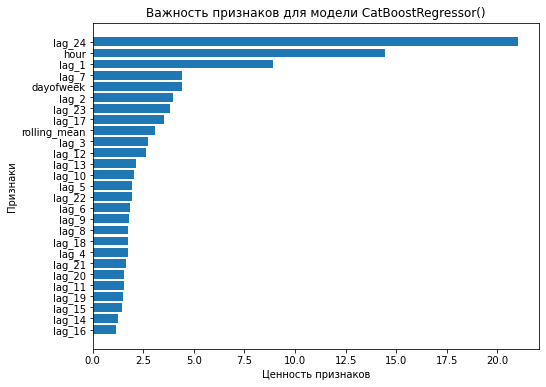

In [42]:
model = gs.best_estimator_.named_steps['model']
importance = model.feature_importances_
feature_names = train.columns
importance_df = pd.DataFrame({
    'Признак': feature_names,
    'Важность': importance
}).sort_values(by='Важность', ascending=False)

plt.figure(figsize=(8, 6))
plt.barh(importance_df['Признак'], importance_df['Важность'])
plt.xlabel('Ценность признаков')
plt.ylabel('Признаки')
plt.title('Важность признаков для модели CatBoostRegressor()')
plt.gca().invert_yaxis()
plt.show()

Самыми важными признаками для предсказания является временной сдвиг на сутки, час, сдвиги на один и семь часов, день недели, а остальные признаки оказывают влияние в меньшем объеме. 

## Тестирование

In [43]:
y_pred = best_model.predict(test)

In [44]:
print(f'Метрика RMSE на тестовой выборке: {rmse(y_test, y_pred)}')

Метрика RMSE на тестовой выборке: 41.018257103446686


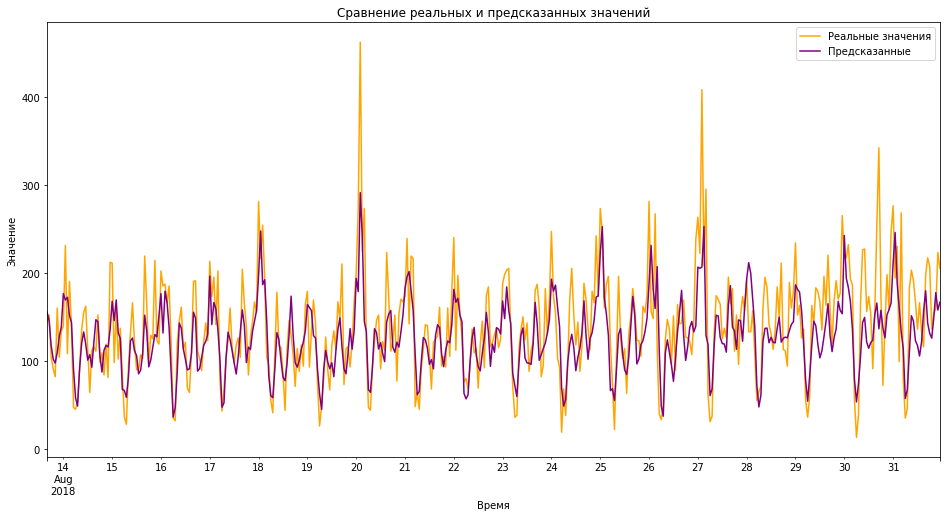

In [45]:
pred = pd.DataFrame({
    'pred': y_pred,
    'real': y_test})
fig, ax = plt.subplots(figsize=(16, 8))
pred['real'].plot(ax=ax, color='orange', label='Реальные значения')
pred['pred'].plot(ax=ax, color='purple', label='Предсказанные')
ax.set_title('Сравнение реальных и предсказанных значений')
ax.set_xlabel('Время')
ax.set_ylabel('Значение')
ax.legend()
plt.show()

Судя по графику, некоторые часы пикового спроса модель предсказывает недостаточно точно, но это скорее связано с их нетипичностью, но в целом, модель достаточно хорошо распознала закономерности. 
Оценим модель базовым способом — предыдущим значением ряда.

In [46]:
pred_previous = y_test.shift(1)
pred_previous.iloc[0] = y_train.iloc[-1]
print(f'Метрика RMSE на основе предсказания предыдущими значениями: {rmse(y_test, pred_previous)}')

Метрика RMSE на основе предсказания предыдущими значениями: 58.881776776551476


Точность предсказания модели гораздо лучше, чем прогноз предыдущим значением ряда.

## Вывод

Для подготовки данных к обучению моделей мы провели ресемплирование по одному часу и создали новые признаки: признаки, основанные на времени (час и день недели), а также 24 столбца с отстающими значениями, что соответствует суткам, чтобы модель могла учитывать предыдущие часы при прогнозировании, и установим размер окна скользящего среднего равным 24 часам.

Сравнив результаты моделей, мы определили, что CatBoostRegressor с параметрами скорости обучения 0,05, максимальной глубиной дерева решений в модели - 6 и количеством деревьев в ансамбле 600 показала наилучшую производительность по метрике RMSE на тренирочных данных. Вторым по качеству предсказания с незначительным отставанием оказался LGBMRegressor, однако его время обучения оказалось значительно ниже.

Метрика RMSE на тестовой выборке для модели CatBoostRegressor составила 41.02, что значительно лучше, чем прогнозирование предыдущими значениями ряда (58.88).

Наиболее важным признаком для прогноза оказался времнные сдвиги на один и двадцать четыре часа, час, что вполне логично, учитывая цикличность заказов в течение дня. 

